In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from sklearn import metrics

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from my_utils import dotdict

In [ ]:
from wandb_sweep import get_dls, get_learner

In [ ]:
from model_eval import get_preds, plot_CM, plot_CM_PR, plot_top_losses_glitches

In [ ]:
import wandb

api = wandb.Api()

In [ ]:
sweep_id = "m4nqsh6e"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
best_run_config = sweep.best_run().config

wandb: Sorting runs by -summary_metrics.combined_f1_time


In [ ]:
config = dotdict(best_run_config)
config.correct_labels = True
config.inference = True
config.real_gw_eval = True

In [ ]:
config.real_gw_version = 3
# version with shift and vmax=50

In [ ]:
dls, _, n_channels = get_dls(config)
learner = get_learner(config, dls, n_channels)
vocab = list(learner.dls.train_ds.class_dict.keys())
learner.load(f"{sweep_id}_run{config.experiment_no}")

<fastai.learner.Learner>

<matplotlib.image.AxesImage>

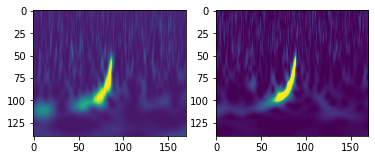

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1741][0][0])
axes[1].imshow(dls.loaders[2].dataset[0][0][0])

<matplotlib.image.AxesImage>

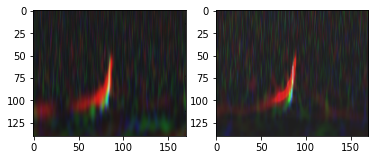

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1741][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[0][0].permute(1, 2, 0))

<matplotlib.image.AxesImage>

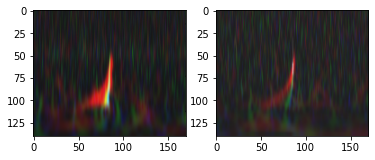

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1742][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[1][0].permute(1, 2, 0))

<matplotlib.image.AxesImage>

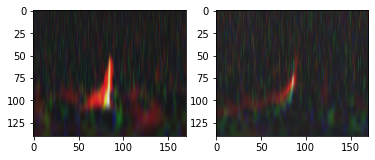

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1743][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[15][0].permute(1, 2, 0))

In [ ]:
dls.loaders[2].dataset[1][0].max()

tensor(0.8431)

In [ ]:
gws = dls[2].one_batch()
gws[0].mean(dim=[0, 2, 3]), gws[0].std(dim=[0, 2, 3])

(tensor([0.1594, 0.1569, 0.1531]), tensor([0.0745, 0.0719, 0.0569]))

In [ ]:
# gspy stats:  
(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1158, 0.0853, 0.0719]))

(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1158, 0.0853, 0.0719]))

In [ ]:
dls.train_ds[1743][0].mean(dim=[1, 2]), dls.train_ds[1743][0].std(dim=[1, 2])

(tensor([0.1557, 0.1302, 0.1245]), tensor([0.1219, 0.0668, 0.0489]))

The real GWs have means and stds different thatn the original dset.  
They are even further than the Chirps present in gspy.

In [ ]:
preds, targets, soft_preds, y_true, y_pred = get_preds(learner, ds_idx=2)

In [ ]:
y_true, tensor([int(y) for y in y_pred])

(tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 tensor([ 4,  4, 11, 10, 11, 17, 21, 10, 11, 11, 11, 11, 11, 21, 11,  4, 11, 12,
         11, 21, 11, 11]))

In [ ]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=np.arange(22))
acc = metrics.accuracy_score(y_true, y_pred) * 100
f1 = metrics.f1_score(y_true, y_pred, average="macro") * 100
print(f"Overall accuracy: {acc:.2f}%")
print(f"Macro-averaged F1-score: {f1:.2f}%")

Overall accuracy: 13.64%
Macro-averaged F1-score: 4.00%


In [ ]:
metrics.top_k_accuracy_score(y_true, soft_preds, labels=np.arange(22), k=5)

0.22727272727272727

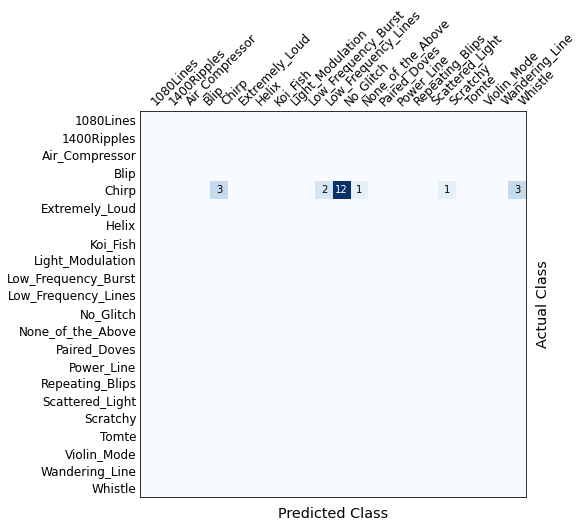

In [ ]:
fig, axes = plot_CM(cm, y_true=y_true, y_pred=y_pred, vocab=vocab, figsize=(8, 8))
#fig.savefig("../figs/glitches/15_baseline_test_cm.pdf", dpi=600, bbox_inches="tight")

In [ ]:
interp = Interpretation.from_learner(learner, ds_idx=2)
channel_list = [0] * 22

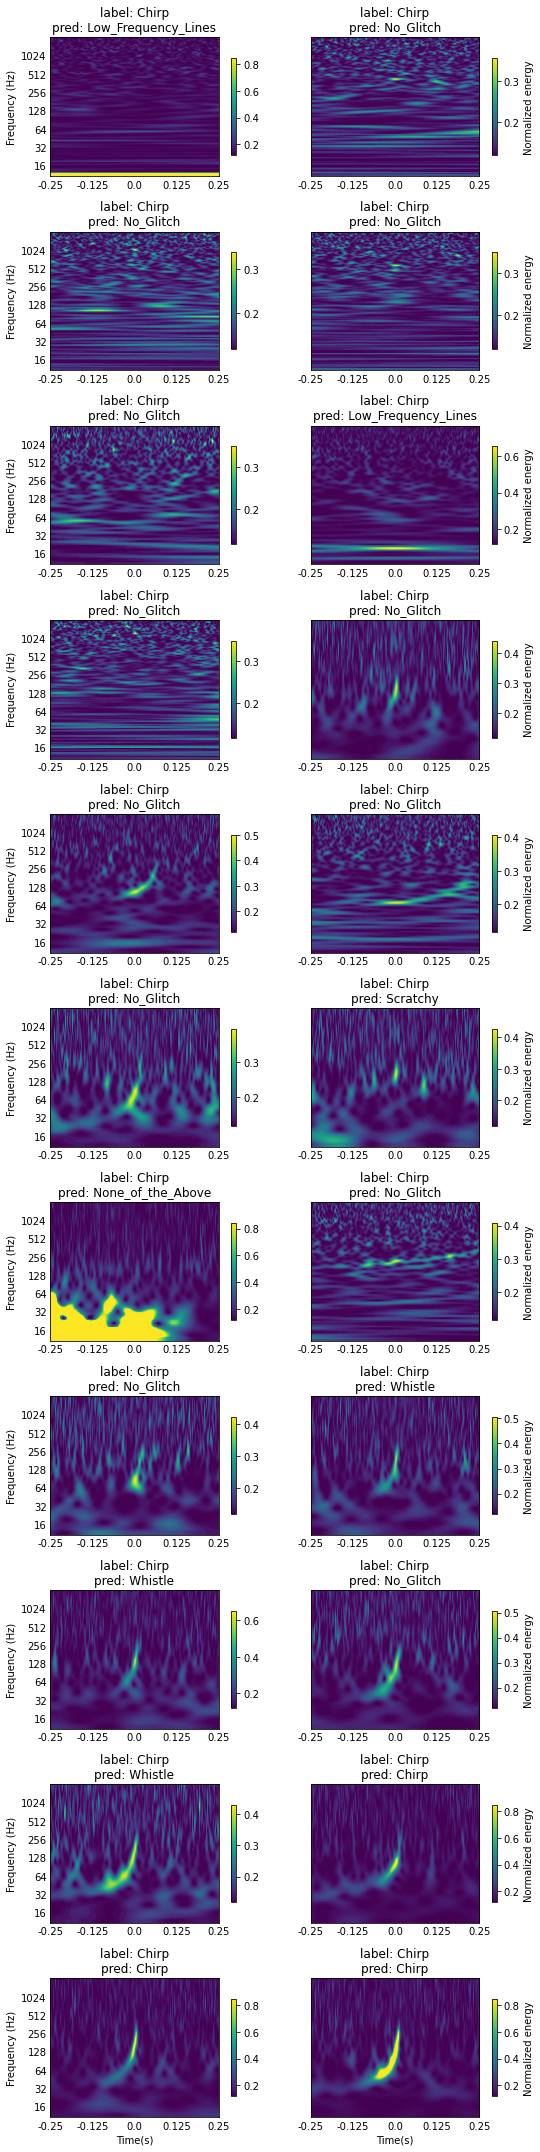

In [ ]:
fig, ax = plot_top_losses_glitches(interp, learner, vocab=vocab, ds_idx=2,
    y_preds=y_pred, channel_list=channel_list,
    largest=True, nrows=11, ncols=2,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(8, 30)
)

In [ ]:
top_losses = interp.top_losses(22)

In [ ]:
for idx in top_losses[1][-6:]:
    top5 = preds[idx].topk(5)
    print([f'{vocab[idx]}: {top5[0][i]:.2e}' for i, idx in enumerate(top5[1])])

['Whistle: 7.72e-01', 'Scratchy: 1.53e-01', 'No_Glitch: 5.59e-02', '1080Lines: 5.26e-03', 'Wandering_Line: 4.48e-03']
['No_Glitch: 5.15e-01', 'Whistle: 3.15e-01', 'Chirp: 5.51e-02', 'Power_Line: 3.60e-02', 'Scratchy: 3.26e-02']
['Whistle: 6.01e-01', 'Chirp: 1.02e-01', 'No_Glitch: 9.75e-02', 'Scratchy: 8.64e-02', 'Power_Line: 5.74e-02']
['Chirp: 9.91e-01', 'Whistle: 6.44e-03', 'Power_Line: 1.35e-03', 'None_of_the_Above: 6.71e-04', 'Tomte: 2.31e-04']
['Chirp: 9.91e-01', 'Whistle: 6.39e-03', 'Power_Line: 1.01e-03', 'Blip: 3.46e-04', 'No_Glitch: 2.25e-04']
['Chirp: 1.00e+00', 'Power_Line: 1.96e-05', 'Whistle: 1.86e-06', 'Paired_Doves: 2.39e-07', 'Koi_Fish: 1.55e-07']


##### Changing mean and std to match gspy

In [ ]:
config.real_gw_normalize = True

In [ ]:
dls, _, n_channels = get_dls(config)
learner = get_learner(config, dls, n_channels)
vocab = list(learner.dls.train_ds.class_dict.keys())
learner.load(f"{sweep_id}_run{config.experiment_no}")

<fastai.learner.Learner>

<matplotlib.image.AxesImage>

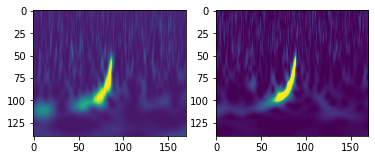

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1741][0][0])
axes[1].imshow(dls.loaders[2].dataset[0][0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<matplotlib.image.AxesImage>

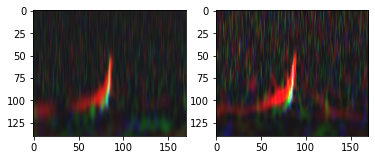

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1741][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[0][0].permute(1, 2, 0))

In [ ]:
dls.loaders[2].dataset[1][0].max()

tensor(1.6722)

In [ ]:
gws = dls[2].one_batch()
gws[0].mean(dim=[0, 2, 3]), gws[0].std(dim=[0, 2, 3])

(tensor([0.1782, 0.1513, 0.1417]), tensor([0.1627, 0.1289, 0.0958]))

In [ ]:
# gspy stats:  
(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1158, 0.0853, 0.0719]))

(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1158, 0.0853, 0.0719]))

In [ ]:
dls.train_ds[1743][0].mean(dim=[1, 2]), dls.train_ds[1743][0].std(dim=[1, 2])

(tensor([0.1557, 0.1302, 0.1245]), tensor([0.1219, 0.0668, 0.0489]))

The real GWs have means and stds matching the original dset.  
They are different that the example chirps, though.

In [ ]:
preds, targets, soft_preds, y_true, y_pred = get_preds(learner, ds_idx=2)

In [ ]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=np.arange(22))
acc = metrics.accuracy_score(y_true, y_pred) * 100
f1 = metrics.f1_score(y_true, y_pred, average="macro") * 100
print(f"Overall accuracy: {acc:.2f}%")
print(f"Macro-averaged F1-score: {f1:.2f}%")

Overall accuracy: 4.55%
Macro-averaged F1-score: 2.90%


In [ ]:
metrics.top_k_accuracy_score(y_true, soft_preds, labels=np.arange(22), k=5)

0.13636363636363635

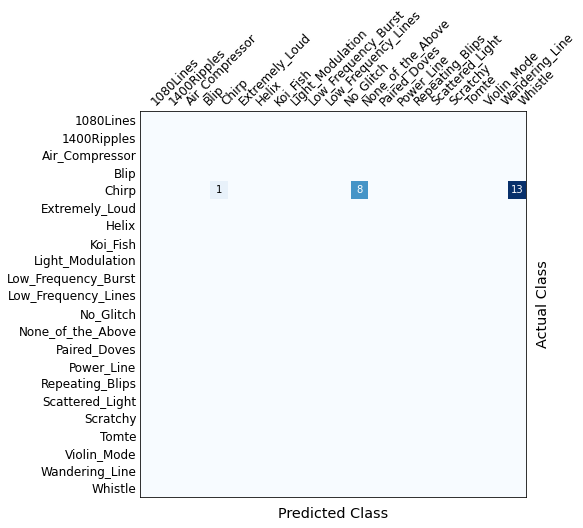

In [ ]:
fig, axes = plot_CM(cm, y_true=y_true, y_pred=y_pred, vocab=vocab, figsize=(8, 8))

The normalization changed many preds to whistles.

In [ ]:
interp = Interpretation.from_learner(learner, ds_idx=2)
channel_list = [0]*22

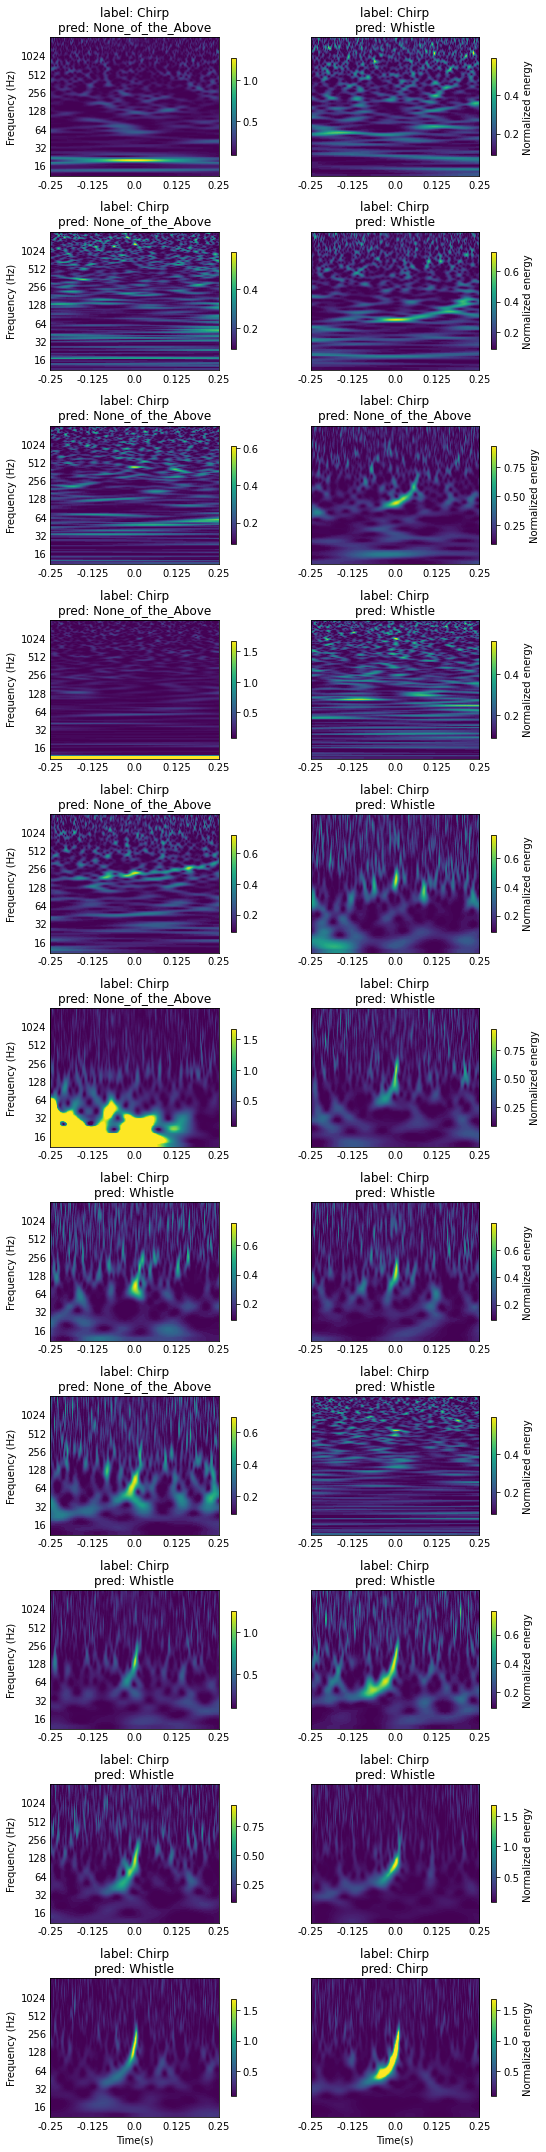

In [ ]:
fig, ax = plot_top_losses_glitches(interp, learner, vocab=vocab, ds_idx=2,
    y_preds=y_pred, channel_list=channel_list,
    largest=True, nrows=11, ncols=2,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(8, 30)
)

In [ ]:
top_losses = interp.top_losses(22)

In [ ]:
for idx in top_losses[1][-6:]:
    top5 = preds[idx].topk(5)
    print([f'{vocab[idx]}: {top5[0][i]:.2e}' for i, idx in enumerate(top5[1])])

['Whistle: 6.82e-01', 'None_of_the_Above: 3.17e-01', 'Violin_Mode: 5.19e-04', 'Wandering_Line: 3.11e-04', 'Koi_Fish: 1.57e-04']
['Whistle: 9.39e-01', 'None_of_the_Above: 6.05e-02', 'Wandering_Line: 1.39e-04', 'Violin_Mode: 1.31e-04', 'Koi_Fish: 1.26e-04']
['Whistle: 8.46e-01', 'None_of_the_Above: 1.50e-01', 'Violin_Mode: 1.50e-03', 'Wandering_Line: 6.07e-04', 'Koi_Fish: 5.02e-04']
['Whistle: 9.40e-01', 'None_of_the_Above: 5.65e-02', 'Chirp: 2.59e-03', 'Koi_Fish: 6.83e-04', 'Violin_Mode: 3.34e-04']
['Whistle: 8.97e-01', 'None_of_the_Above: 5.04e-02', 'Chirp: 4.95e-02', 'Koi_Fish: 1.42e-03', 'Wandering_Line: 8.73e-04']
['Chirp: 9.93e-01', 'Whistle: 4.46e-03', 'None_of_the_Above: 1.48e-03', 'Koi_Fish: 4.10e-04', 'Power_Line: 1.22e-04']
